In [1]:
# https://developers.google.com/optimization/introduction/python
# to do: 
# all or nothing flow - maximum one inflow and one outflow only
# prune variables for the model (so that it is not 100k variables)
# plotting - reduce clutter

In [2]:
%reset -sf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Define problem

In [3]:
df = pd.read_pickle("../preprocessing/processed_dataframe.pkl")
# df

In [4]:
nodes = pd.DataFrame()
nodes["supplies"] = df["TOTAL"]
nodes["x"] = df["x_centre"]
nodes["y"] = df["y_centre"]

start_nodes = []
end_nodes   = []
unit_costs  = []
for i,row in df.iterrows():
    for adj, cst in zip(row["adjacent"], row["shared_param"]):
        start_nodes.append(i)
        end_nodes.append(adj)
        unit_costs.append(cst)

edges = pd.DataFrame()
edges["start_nodes"] = start_nodes
edges["end_nodes"]   = end_nodes
edges["unit_costs"]  = unit_costs
edges["capacities"]  = [9999999]*len(start_nodes) # disabled
edges["flows"]       = [0]*len(start_nodes)
edges["flowing"]     = [0]*len(start_nodes)
edges["names"]       = "x"+edges[["start_nodes",
                                  "end_nodes"]].astype(str).apply('-'.join, axis=1)
edges.index = edges["names"]
N = len(nodes) # the number of nodes at init

In [5]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x236-229,236,229,0.022766,9999999,0,0,x236-229
x159-186,159,186,0.010708,9999999,0,0,x159-186
x293-278,293,278,0.003264,9999999,0,0,x293-278
x170-172,170,172,0.002653,9999999,0,0,x170-172
x208-205,208,205,0.000338,9999999,0,0,x208-205


# Augment nodes to a common sink

In [6]:
def augment_nodes(nodes, edges):
    for i,ss in enumerate(nodes["supplies"]):
        edges.loc[len(edges)] = [i, len(nodes), 0, 9999999, 0, 0,
                                 "x"+str(i)+"-"+str(len(nodes))]
    nodes.loc[len(nodes)] = [-sum(nodes["supplies"]), 103.5, 1.2]
    edges.index = edges["names"]
    return nodes, edges

In [7]:
nodes, edges = augment_nodes(nodes, edges)
# nodes
# edges

# Generate adjacency matrix

In [8]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    flowing = edges["flowing"]
    names = edges["names"]
    
    matrix_unit_costs = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_capacities = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flows      = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flowing    = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_names      = [["x"+str(i)+"-"+str(j)
                          for i in range(N+1)] 
                         for j in range(N+1)]
    
    for x,y,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g
        
    for y,x,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names, matrix_flowing

(matrix_unit_costs, matrix_capacities, 
 matrix_flows, matrix_names, matrix_flowing) = get_adjacency_matrix(edges)

In [9]:
# matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

# Visualisation

In [10]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x161-70,161,70,0.003423,9999999,0,0,x161-70
x247-249,247,249,0.014580,9999999,0,0,x247-249
x42-40,42,40,0.005545,9999999,0,0,x42-40
x91-318,91,318,0.000000,9999999,0,0,x91-318
x154-152,154,152,0.014557,9999999,0,0,x154-152


In [11]:
def plot_graph(nodes, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]

    G = nx.DiGraph()
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        G.add_edge(x, y, cost=z, capacity=c, flow=f, name=n)

    labeldict = {}
    for i,s in enumerate(nodes["supplies"]):
        labeldict[i] = s

    fig, ax = plt.subplots(figsize=(14,9))
    
    pos=nx.circular_layout(G)
    pos={}
    for i,node in nodes.iterrows():
        pos[i] = [node["x"], node["y"]]
    
    for edge in G.edges(data=True):
        w = edge[2]['flow']
        if w > 0:
            size = np.log(1+w)
            nx.draw_networkx_edge_labels(G,pos, edgelist=[(edge[0],edge[1])], 
                                         edge_labels = {(edge[0],edge[1]): w})
            nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], 
                                   width=size, arrowsize=size*10)
            
    nx.draw_networkx_nodes(G, pos, with_labels=True, font_size=15, 
                           node_size=200, 
                           node_color="yellow")
    nx.draw_networkx_labels(G, pos, labels=labeldict)
    
    ax.autoscale()
    ax.set_aspect(1)
    ax.margins(0.1)
    plt.show()

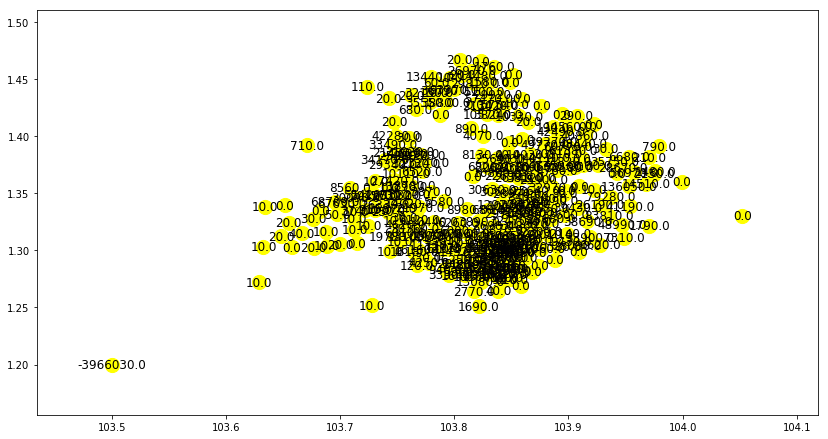

In [12]:
plt.show()
plot_graph(nodes, edges)

# Min-cost flow as a linear program

In [13]:
solver = pywraplp.Solver('hello_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define variables and capacities
infinity = solver.infinity()
X = [[solver.NumVar(0.0, matrix_capacities[i][j], 'x'+str(i)+"-"+str(j)) 
      for j in range(N+1)]
     for i in range(N+1)]

# define supplies
for i in range(N):
    solver.Add(sum([X[i][j] for j in range(N+1)])
             - sum([X[j][i] for j in range(N+1)])
            == nodes["supplies"][i])

In [14]:
B = [[solver.IntVar(0.0, 1.0, 'b'+str(i)+"-"+str(j)) 
      for j in range(N+1)]
     for i in range(N+1)]

In [15]:
%%time
for i in range(N+1):
    for j in range(N+1):
        if matrix_capacities[i][j] > 0:
            solver.Add(X[i][j] <= 1200000*B[i][j])
    solver.Add(sum([B[i][j] for j in range(N+1)]) <= 1)

CPU times: user 473 ms, sys: 3.38 ms, total: 476 ms
Wall time: 476 ms


In [16]:
# for i in range(N):
#     solver.Add(X[i][N] <= 1200000*B[i][N])
#     solver.Add(X[N][i] <= 1200000*B[N][i])
#     solver.Add(sum([B[i][j] for j in range(N)]) <= 1)

In [17]:
# limit number of cstcs
# solver.Add(sum([B[i][N] for i in range(N+1)]) <= 400)
# https://groups.google.com/forum/#!topic/or-tools-discuss/UQraf8LYJ14 ??

In [18]:
# for i in range(N):
#     print(X[N][i].solution_value() for j in range(N)]))

In [19]:
# define objective
solver.Minimize(sum([sum([matrix_unit_costs[i][j] * X[i][j]
                          for j in range(N+1)])
                     for i in range(N+1)]))

solver.set_time_limit(2*1000)

print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

Number of variables = 203522
Number of constraints = 2943


In [20]:
# print(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

In [21]:
status = solver.Solve()

# Visualise output

In [22]:
print('NOT_SOLVED: ', status == pywraplp.Solver.NOT_SOLVED)
print('Stopped by time limit: ', status == pywraplp.Solver.FEASIBLE)
print('Optimal: ', status == pywraplp.Solver.OPTIMAL)
print('Infeasible: ', status == pywraplp.Solver.INFEASIBLE)

NOT_SOLVED:  False
Stopped by time limit:  False
Optimal:  True
Infeasible:  False


In [23]:
print('Solution:')
print('Objective value =', solver.Objective().Value())
print('')
print('Advanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations'   % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

Solution:
Objective value = 0.0

Advanced usage:
Problem solved in 4225.000000 milliseconds
Problem solved in 0 iterations
Problem solved in 0 branch-and-bound nodes


In [24]:
matrix_flows = [[x.solution_value() for x in xxx] for xxx in X]
matrix_flowing = [[b.solution_value() for b in bbb] for bbb in B]
for i,row in enumerate(matrix_flows):
    for j,cell in enumerate(row):
        if matrix_flows[i][j] > 0:
            edges.at["x"+str(i)+"-"+str(j),"flows"] = matrix_flows[i][j]
            edges.at["x"+str(i)+"-"+str(j),"flowing"] = matrix_flowing[i][j]

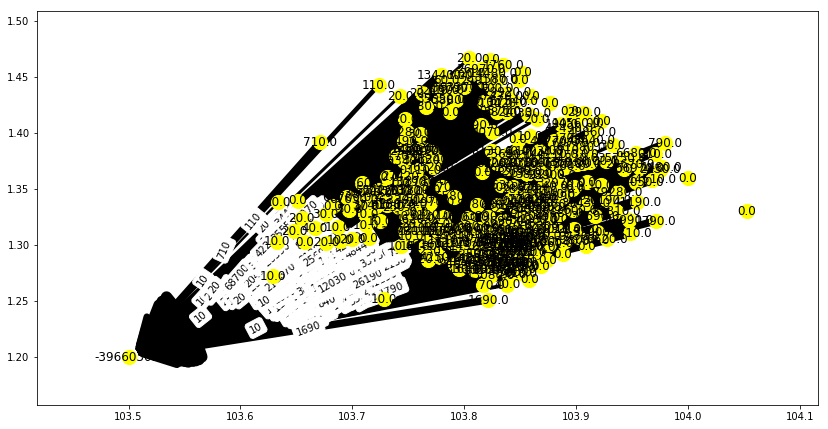

In [25]:
plot_graph(nodes, edges)

In [26]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x195-210,195,210,0.002554,9999999,0,0,x195-210
x174-113,174,113,0.017806,9999999,0,0,x174-113
x168-199,168,199,0.000115,9999999,0,0,x168-199
x276-318,276,318,0.000000,9999999,20,1,x276-318
x34-4,34,4,0.004813,9999999,0,0,x34-4


In [27]:
edges[edges["flows"]>0].sort_index().sort_values(by="end_nodes").tail(20)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x174-318,174,318,0.0,9999999,10440,1,x174-318
x167-318,167,318,0.0,9999999,3890,1,x167-318
x182-318,182,318,0.0,9999999,7760,1,x182-318
x184-318,184,318,0.0,9999999,10400,1,x184-318
x199-318,199,318,0.0,9999999,14020,1,x199-318
x198-318,198,318,0.0,9999999,26330,1,x198-318
x197-318,197,318,0.0,9999999,39430,1,x197-318
x195-318,195,318,0.0,9999999,18780,1,x195-318
x194-318,194,318,0.0,9999999,3870,1,x194-318


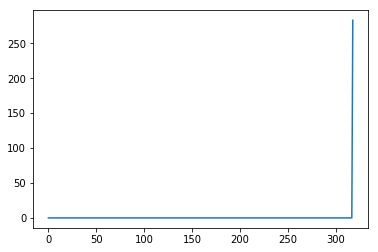

In [28]:
plt.plot([sum([r > 0 for r in row]) for row in np.transpose(matrix_flows)])
plt.show()

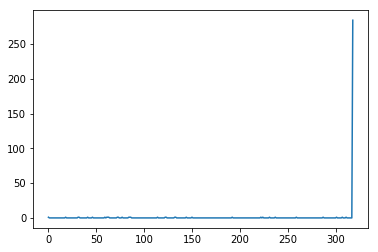

In [29]:
plt.plot([sum(row) for row in np.transpose(matrix_flowing)])

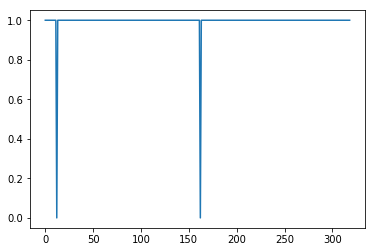

In [30]:
plt.plot([sum(row) for row in matrix_flowing])

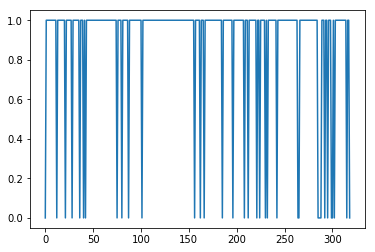

In [31]:
plt.plot([sum([r > 0 for r in row]) for row in matrix_flows])
plt.show()

In [32]:
index = [sum([r > 0 for r in row]) for row in matrix_flows].index(2)
index

ValueError: 2 is not in list

In [ ]:
edges[edges["end_nodes"] == index]

In [ ]:
edges[edges["start_nodes"] == index]

In [ ]:
nodes.loc[index]

In [ ]:
sum(nodes["supplies"])